In [32]:
import requests
import json 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as mdates 
from tabulate import tabulate
import math
import plotly as py
import plotly.express as px


In [33]:
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor


In [34]:
#----------------------------- Load output json --------------------------



url = 'https://raw.githubusercontent.com/1Hive/pollen/gh-pages/output/credResult.json'
r = requests.get(url)
cred = json.loads(r.text)

#with open('credResult.json', 'r') as f:
#  cred = json.load(f) 





In [35]:
# -------------------------- Set dates time-filtering ------------------------

# start_date = '2018/11/10 18:56:36'
start_date = '2020/10/01 00:00:00'
end_date = '2020/10/18 00:00:00'


start_datetime = datetime.datetime.strptime(start_date, '%Y/%m/%d %H:%M:%S')
end_datetime = datetime.datetime.strptime(end_date, '%Y/%m/%d %H:%M:%S')

num_nodes = len(cred[1]['credData']['nodeSummaries']) 
nodes = []

for i in range(num_nodes):

	# if (cred[1]['weightedGraph'][1]['graphJSON'][1]['sortedNodeAddresses'][i][1] == 'discourse'): 
	node = {}
	node['address'] = cred[1]['weightedGraph'][1]['graphJSON'][1]['sortedNodeAddresses'][i]
	node['cred'] = cred[1]['credData']['nodeSummaries'][i]['cred']
	if cred[1]['credData']['nodeOverTime'][i] is None: 
		node ['credOverTime'] = []
	else:
		node ['credOverTime'] = cred[1]['credData']['nodeOverTime'][i]['cred']  

	node['description'] = cred[1]['weightedGraph'][1]['graphJSON'][1]['nodes'][i]['description'] 
	node['timestamp'] = cred[1]['weightedGraph'][1]['graphJSON'][1]['nodes'][i]['timestampMs'] 
	node['user'] = ''

	if (node['address'][2] == 'IDENTITY'):
		node['user'] = cred[1]['weightedGraph'][1]['graphJSON'][1]['nodes'][i]['description']
	
	nodes.append(node)


In [36]:
# --------- ----------------- filter nodes by type --------------------------


nodes_filt = [ node for node in nodes if (node['address'][2]== 'post') ]
# nodes_filt = [ node for node in cred[1]["orderedNodes"] if (node['address'][2] == 'topic' )] # Filter by topic
# nodes_filt = [ node for node in cred[1]["orderedNodes"] if (node['address'][2] == 'topic' or node['address'][2]== 'post') ] # Filter by topic AND post
# nodes_filt = cred[1]["orderedNodes"]  # No filter (pass through..)


In [37]:
# --------------------------- filter nodes by dateTime --------------------------

nodes_time_filt = [ node for node in nodes_filt if (datetime.datetime.fromtimestamp(node['timestamp']/1000 ) >= \
		start_datetime and datetime.datetime.fromtimestamp(node['timestamp']/1000 ) <= end_datetime) ]


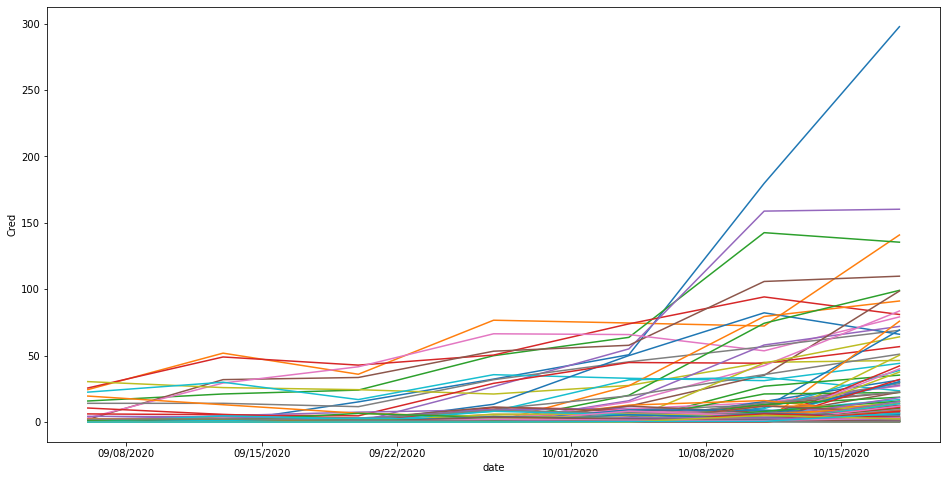

In [38]:
# ------------------------- Plot top users Cred over time --------------------

# filter user nodes 
nodes_filt = [ node for node in nodes if (node['address'][2] == 'IDENTITY') ]
span = 8	
num_display = 100


nodes_sorted5 = sorted(nodes_filt, key=lambda e: sum(e['credOverTime'][-span:-1]), reverse=True)

top_nodes = nodes_sorted5[:num_display]
new_list = [i['endTimeMs'] for i in cred[1]['credData']['intervals']]



intervals = new_list[-span:-1]

EndDateTime = []						# Get datetime of intervals (end)
for i in range(len(intervals)):
	EndDateTime.append(datetime.datetime.fromtimestamp(intervals[i]/1000 )) 

for i in range(num_display):

	# plt.plot(EndDateTime,top_nodes[i]['credOverTime'][-span:], label=top_nodes[i]['address'][4])
	plt.plot(EndDateTime,top_nodes[i]['credOverTime'][-span:-1], label=top_nodes[i]['description'])



fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size


plt.xlabel('date')
plt.ylabel('Cred')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.show()


In [39]:
# ------------------------- Create pandas dataframe --------------------



df2 = pd.DataFrame(top_nodes,columns=['user', 'cred', 'credOverTime'])

df3 = pd.DataFrame(df2.credOverTime.tolist(), index= df2.index)
df4 = pd.concat([df2['user'],df2['cred'], df3], axis=1, sort=False)

# add extra colum with user name for sorting
df4['User.Upper'] = df4['user'].str.upper()
df4.sort_values(by='User.Upper', inplace=True)
df4.to_csv(r'dataframe5.csv', index = False)

df4

,user,cred,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,User.Upper
67,-inh-Ti-n-H-i,28.478759,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,14.317550,14.124844,-INH-TI-N-H-I
94,6suns,8.796311,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200011,3.360166,3.047277,1.462092,0.726765,6SUNS
71,Adam-Stallard,16.773332,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014604,0.033461,0.193366,0.765940,0.419437,0.215831,1.186230,0.600244,0.416078,4.012442,2.482970,1.503344,1.317186,1.999160,1.103181,0.509859,ADAM-STALLARD
68,Aitor,37.309169,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018787,0.010264,0.005204,0.002963,0.001775,0.101876,13.967545,23.200754,AITOR
82,Akim-Bara,15.064237,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,9.917271,5.110602,AKIM-BARA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,xDaiFandom,84.974794,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075809,10.905198,9.417207,6.285136,30.040659,28.250785,XDAIFANDOM
56,Yalor,21.166758,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.773247,5.978462,5.329983,2.656159,1.428907,YALOR
97,Yalor--EST-,7.671861,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211642,2.034851,2.480150,1.266182,0.767573,0.464799,0.261938,0.121733,0.062992,YALOR--EST-
63,YoungKidWarrior,30.347696,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,

In [40]:
# ------------------------- Plot sorted by username --------------------

fig = px.bar(df4, x="user", y="cred", title='Cumulated Cred Balance - Sorted Alphabetically',width=1800, height=800)
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', size=12))
fig.show()

In [41]:
df4.sort_values(by='cred', inplace=True, ascending=False)
fig = px.bar(df4, x="user", y="cred", title='Cumulated Cred Balance - Sorted by Cred',width=1800, height=800)
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', size=12))
fig.show()
